# Benchmarking of integration methods - SCVI
In this notebook SCVI integration will be tested (real run is performed as slurm job because this takes too long)

In [1]:
import sys
print(sys.executable)
print(sys.version)
print(sys.version_info)

/home/hers_basak/jjiang/jack/miniconda/envs/scarches/bin/python
3.9.18 (main, Sep 11 2023, 13:41:44) 
[GCC 11.2.0]
sys.version_info(major=3, minor=9, micro=18, releaselevel='final', serial=0)


In [2]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))#embed HTML within IPython notebook and make containers 90% of screen
import numpy as np
import pandas as pd
import anndata as ad
import scanpy as sc
import seaborn as sns
import os
import matplotlib.pyplot as plt
import scvi
import torch

%matplotlib inline
sc.settings.verbosity = 0             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.set_figure_params(dpi=80, facecolor='white') #figure resolution and background color

# This is used
# os.path.join('data/'+object_names[i][6:10]+'_preprocessed.h5ad')
#sc.logging.print_versions()

OSError: /hpc/hers_basak/rnaseq_data/Basaklab/jjiang/miniconda/envs/scarches/lib/python3.9/site-packages/torchaudio/lib/libtorchaudio.so: undefined symbol: _ZN2at4_ops6conv1d4callERKNS_6TensorES4_RKN3c108optionalIS2_EENS5_8ArrayRefIlEESB_SB_l

In [3]:
#set data path
os.chdir('/home/hers_basak/jjiang/jack/outputs/deliverables/5_integration/data/scvi/')

Loading previous made model

In [4]:
model = scvi.model.SCVI.load('/home/hers_basak/jjiang/jack/outputs/deliverables/5_integration/data/scvi/models/scvi_model_0/')

INFO     File                                                                                                      
         /home/hers_basak/jjiang/jack/outputs/deliverables/5_integration/data/scvi/models/scvi_model_0/model.pt    
         already downloaded                                                                                        


/home/hers_basak/jjiang/jack/miniconda/envs/scarches/lib/python3.9/site-packages/lightning/fabric/plugins/environments/slurm.py:168: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/hers_basak/jjiang/jack/miniconda/envs/scarches ...
  rank_zero_warn(
/home/hers_basak/jjiang/jack/miniconda/envs/scarches/lib/python3.9/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [5]:
model

SCVI Model with the following params: 
n_hidden: 128, n_latent: 10, n_layers: 1, dropout_rate: 0.1, dispersion: gene, gene_likelihood: zinb, 
latent_distribution: normal
Training status: Trained
Model's adata is minified?: False

In [4]:
files=['/home/hers_basak/jjiang/jack/outputs/deliverables/5_integration/data/complete_base.h5ad']
names=['complete']
object_names_merged=list()
numberobj = len(files)

for i in range(numberobj):
    object_names_merged.append("adata"+"_"+names[i])
    locals()[object_names_merged[i]] = sc.read(files[i]) 
    print(object_names_merged[i],' is loaded')

adata_complete  is loaded


/home/hers_basak/jjiang/jack/miniconda/envs/scarches/lib/python3.9/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [12]:
atlases=['altena','agarwal','siletti','smajic','wang','welch']
for i in atlases:
    print(len(adata_complete.obs_names[adata_complete.obs['atlas']==i]))

85044
9214
287523
29495
43477
67467


"For a better model performance it is necessary to select HVGs. We are doing this by applying the scanpy.pp function highly_variable_genes(). The n_top_genes is set to 2000 here. However, if you have more complicated datasets you might have to increase number of genes to capture more diversity in the data." So we will use 4k as recommended number of hvg is between 2k and 6k.

In [5]:
sc.pp.highly_variable_genes(
    adata_complete,
    n_top_genes=4000,
    batch_key="atlas",
    subset=True)

/home/hers_basak/jjiang/jack/miniconda/envs/scarches/lib/python3.9/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/hers_basak/jjiang/jack/miniconda/envs/scarches/lib/python3.9/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [6]:
adata_complete.X = adata_complete.raw[:, adata_complete.var_names].X

scVI expects only non-normalized (count) data on highly variable genes

In [15]:
print(adata_complete.raw.X)

  (0, 15011)	1
  (0, 27456)	1
  (0, 26975)	2
  (0, 28665)	1
  (0, 31823)	4
  (0, 10968)	2
  (0, 17951)	6
  (0, 14029)	2
  (0, 14028)	1
  (0, 38722)	2
  (0, 43148)	2
  (0, 10471)	6
  (0, 25753)	4
  (0, 21438)	3
  (0, 17116)	3
  (0, 18738)	13
  (0, 30442)	1
  (0, 30441)	2
  (0, 30443)	1
  (0, 15456)	3
  (0, 43715)	6
  (0, 16886)	5
  (0, 16885)	1
  (0, 40688)	4
  (0, 15048)	1
  :	:
  (522219, 34500)	1
  (522219, 43150)	1
  (522219, 34041)	1
  (522219, 20735)	1
  (522219, 40698)	1
  (522219, 41451)	1
  (522219, 42272)	1
  (522219, 34352)	1
  (522219, 24020)	2
  (522219, 19015)	2
  (522219, 25606)	2
  (522219, 34597)	1
  (522219, 35320)	1
  (522219, 18989)	1
  (522219, 39162)	1
  (522219, 29393)	1
  (522219, 11662)	1
  (522219, 23289)	1
  (522219, 33877)	2
  (522219, 15210)	1
  (522219, 43810)	1
  (522219, 40752)	1
  (522219, 29721)	1
  (522219, 43500)	1
  (522219, 15481)	2


In [7]:
adata_complete.layers['counts']=adata_complete.X.copy()

Setup the anndata in order to create the model

In [8]:
scvi.model.SCVI.setup_anndata(adata_complete, layer='counts',  batch_key="atlas")

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [9]:
model = scvi.model.SCVI(adata_complete, n_hidden=128, n_latent=10, n_layers=1, dropout_rate=0.1, dispersion='gene', gene_likelihood='zinb', latent_distribution='normal')

In [10]:
model.view_anndata_setup()

Anndata setup with scvi-tools version 1.0.3.

Setup via `SCVI.setup_anndata` with arguments:

{
│   'layer': 'counts',
│   'batch_key': 'atlas',
│   'labels_key': None,
│   'size_factor_key': None,
│   'categorical_covariate_keys': None,
│   'continuous_covariate_keys': None
}

         Summary Statistics          
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃     Summary Stat Key     ┃ Value  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│         n_batch          │   6    │
│         n_cells          │ 522220 │
│ n_extra_categorical_covs │   0    │
│ n_extra_continuous_covs  │   0    │
│         n_labels         │   1    │
│          n_vars          │  4000  │
└──────────────────────────┴────────┘

               Data Registry                
┏━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Registry Key ┃    scvi-tools Location    ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      X       │  adata.layers['counts']   │
│    batch     │ adata.obs['_scvi_batch']  │
│    labels    │ adata.obs['_scvi_labels'] │
└──────────────┴───────────────────────────┘

                  batch State Registry                   
┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃  Source Location   ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['atlas'] │  agarwal   │          0          │
│                    │   altena   │          1          │
│                    │  siletti   │          2          │
│                    │   smajic   │          3          │
│                    │    wang    │          4          │
│                    │   welch    │          5          │
└────────────────────┴────────────┴─────────────────────┘

                     labels State Registry                      
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃      Source Location      ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['_scvi_labels'] │     0      │          0          │
└───────────────────────────┴────────────┴─────────────────────┘

Training the model, epochs=(20000/n_obs)*400 by default, should be fine as long as loss converges

In [11]:
model.train(check_val_every_n_epoch=1
            ,max_epochs=15
            ,batch_size=128
           )

/home/hers_basak/jjiang/jack/miniconda/envs/scarches/lib/python3.9/site-packages/lightning/fabric/plugins/environments/slurm.py:168: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/hers_basak/jjiang/jack/miniconda/envs/scarches ...
  rank_zero_warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/hers_basak/jjiang/jack/miniconda/envs/scarches/lib/python3.9/site-packages/lightning/fabric/plugins/environments/slurm.py:168: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/hers_basak/jjiang/jack/miniconda/envs/scarches ...
  rank_zero_warn(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEV

Epoch 15/15: 100%|██████████| 15/15 [08:12<00:00, 32.05s/it, v_num=1, train_loss_step=1.07e+3, train_loss_epoch=1.15e+3]

`Trainer.fit` stopped: `max_epochs=15` reached.


Epoch 15/15: 100%|██████████| 15/15 [08:12<00:00, 32.82s/it, v_num=1, train_loss_step=1.07e+3, train_loss_epoch=1.15e+3]


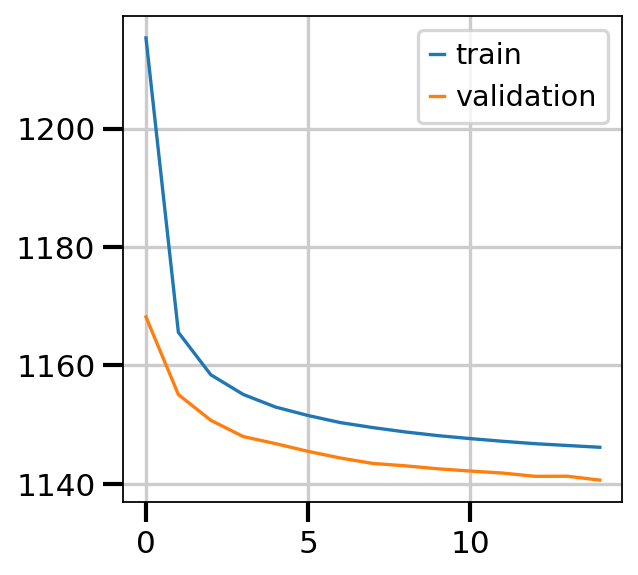

In [12]:
plt.plot(model.history['reconstruction_loss_train']['reconstruction_loss_train'], label='train');
plt.plot(model.history['reconstruction_loss_validation']['reconstruction_loss_validation'], label='validation');
plt.legend()

In [13]:
SCVI_LATENT_KEY = "X_scVI"
adata_complete.obsm[SCVI_LATENT_KEY] = model.get_latent_representation()

In [21]:
model.save('./models/scvi_model_0', save_anndata=True)